In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from glob import glob as glob
import os
import pywt
import cv2
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

In [ ]:
# num_class = 15
# num_train = 20
# num_test = 5
im_size = np.array((192, 168))

In [ ]:
def filter_files(d, num_train, num_test, cond):
    fnames = [os.path.basename(i)[:-4] for i in glob(d+"/*_P00A*.pgm")]
    acc_files = []
    for f in fnames:
        az = int(f[12:16])
        elev = int(f[17:20])
        if cond(az, elev):
            acc_files.append(f)
    samps = np.random.choice(acc_files, num_train+num_test, replace=False)
    return samps[:num_train], samps[num_train:]

def fread(f):
    return plt.imread(f).flatten().T

# def_cond = lambda az, elev: abs(az) <= 45 and abs(elev) <= 45
# def train_test_split(num_classes=5, num_train=5, num_test=3, cond = def_cond):
    
#     class_dirnames = np.random.choice(glob("CroppedYale/*"), size=num_classes, replace=False)
    
#     train_fnames_all, test_fnames_all = np.array([]), np.array([])
    
#     A = np.zeros((np.prod(im_size), num_classes*num_train))
#     y = np.zeros((np.prod(im_size), num_classes*num_test))
    
#     train_gt = np.zeros(num_classes*num_train).astype(int)
#     test_gt = np.zeros(num_classes*num_test).astype(int)
    
#     for i, d in enumerate(class_dirnames):
#         train_fnames, test_fnames = filter_files(d, num_train, num_test, cond)
#         train_fnames_all = np.append(train_fnames_all, train_fnames)
#         test_fnames_all = np.append(test_fnames_all, test_fnames)
#         for j, f in enumerate(train_fnames):
#             idx = (i*num_train+j)
#             A[:,idx] = fread(d+"/"+f+".pgm")
#             train_gt[idx] = i
#         for j, f in enumerate(test_fnames):
#             idx = (i*num_test+j) 
#             y[:,idx] = fread(d+"/"+f+".pgm")
#             test_gt[idx] = i
            
#     return A, y, train_gt, test_gt, (train_fnames_all, test_fnames_all)

def random_sample():
    all_fnames = glob("*/*/*_P00A*.pgm")
    half = len(all_fnames)//2
    np.random.shuffle(all_fnames)
    
    train_fnames = all_fnames[:half]
    test_fnames = all_fnames[half:]
    
    A = np.zeros((np.prod(im_size), len(train_fnames)))
    y = np.zeros((np.prod(im_size), len(test_fnames)))
    
    train_gt = np.zeros(len(train_fnames)).astype(int)
    test_gt = np.zeros(len(test_fnames)).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
        
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

In [ ]:
A, y, train_gt, test_gt, names = random_sample()
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

In [ ]:
names[1]

In [ ]:
# A, y, train_gt, test_gt, names = train_test_split(num_classes = num_class, num_train = num_train, num_test = num_test)
# print(A.shape, y.shape)
# print(train_gt)
# print(test_gt)

In [ ]:
def down_samp(A, ds_factor=16):
    im_size_down = np.ceil(im_size/ds_factor).astype(int)
    A_down = np.zeros((np.prod(im_size_down), A.shape[-1]))
#     print(A_down.shape)
    for i in range(A.shape[-1]):
        A_down[:,i] = A[:,i].reshape(im_size)[::ds_factor, ::ds_factor].flatten()
    return A_down, im_size_down

In [ ]:
def down_samp_pca(A, dim=132):
    # sklearn PCA
    pca = PCA(n_components=dim, svd_solver="auto")
    A_pca = pca.fit_transform(A.T).T
    
    # Manual PCA
#     U, S, Vh = np.linalg.svd(A, full_matrices=True)
#     print(U.shape, S.shape, Vh.shape)
#     A_pca = U[:,:dim].T@A
    return A_pca, pca

In [117]:
def down_samp_wave(A):
    im_vec = A.reshape((*im_size,-1))
    wave_vec = pywt.wavedec2(im_vec, 'haar', axes=(0,1), level=4)
#     low_dim_data = wave_vec[0]
    low_dim_data = ((wave_vec[0] + sum(wave_vec[1]))/4)
#     low_dim_data = wave_vec[0] + sum(wave_vec[1])
    shape = low_dim_data.shape[:2]
    low_dim_data = low_dim_data.reshape(-1, A.shape[-1])
    return (low_dim_data/np.max(low_dim_data, axis=0)*255).astype(np.uint8), shape

In [ ]:
def down_samp_cv(A):
    A_down = np.zeros((120, A.shape[-1]))
    for i in range(A.shape[-1]):
        A_down[:,i] = cv2.resize(A[:,i].reshape(im_size), (12,10)).flatten()
    return A_down, (12,10)

In [106]:
A_ds, ds_shape = down_samp(A, ds_factor=16)

In [118]:
A_wave, wave_shape = down_samp_wave(A)

In [ ]:
A_ds_cv, ds_cv_shape = down_samp_cv(A)

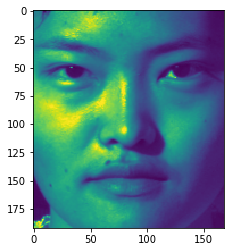

In [119]:
plt.imshow(A[...,0].reshape(im_size))

In [ ]:
plt.imshow(A_ds_cv[...,0].reshape(ds_cv_shape))

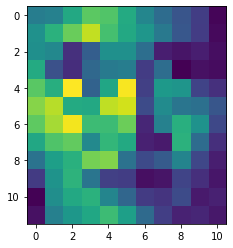

In [120]:
plt.imshow(A_ds[...,0].reshape(ds_shape))

In [122]:
A_wave.shape

(132, 1207)

In [121]:
plt.imshow(A_wave[...,0].reshape(wave_shape))

ValueError: cannot reshape array of size 132 into shape (132,1207)

In [116]:
A_wave[...,0]

array([433.0625, 608.875 , 708.875 , 808.    , 718.9375, 588.1875,
       460.3125, 346.375 , 240.4375, 140.375 ,  28.    , 518.9375,
       657.6875, 844.0625, 758.375 , 608.4375, 550.    , 508.75  ,
       401.    , 237.0625, 125.1875,  43.1875, 526.8125, 590.125 ,
       351.5625, 269.375 , 455.625 , 459.625 , 221.25  , 114.25  ,
       236.75  , 124.5625,  53.625 , 526.4375, 236.1875,  66.25  ,
       285.4375, 485.5   , 443.75  , 216.3125, 167.375 ,  20.75  ,
        58.875 ,  58.8125, 738.0625, 667.3125, 514.25  , 388.5625,
       778.75  , 659.9375, 275.    , 466.5625, 362.875 , 154.5   ,
       174.6875, 846.875 , 938.625 , 664.0625, 850.1875, 845.5625,
       612.375 , 234.5625, 485.625 , 397.5625, 412.6875, 221.375 ,
       751.375 , 902.    , 952.    , 582.3125, 695.125 , 603.9375,
       113.    , 564.75  , 623.5625, 424.    , 168.4375, 573.5   ,
       715.125 , 663.1875, 690.1875, 302.9375, 354.5   ,  66.875 ,
       347.5625, 541.    , 283.0625,  93.1875, 432.375 , 586.5

In [ ]:
A_pca, _ = down_samp_pca(A)

In [ ]:
A_pca.shape

In [ ]:
plt.imshow(A_pca)

In [ ]:
# def delta(x, i):
#     assert i < num_class
#     out = np.zeros(len(x))
#     idxs = slice(i*num_class, i*num_class+num_train)
#     out[idxs] = x[idxs]
#     return out

In [ ]:
def delta_i(x, i, gt):
    return np.where(gt==i, x, 0)

In [ ]:
min(test_gt)

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def identity(A, y, class_idxs):
    A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
#     print(A, y)
    prob = Lasso(fit_intercept=False, alpha=1e-4, max_iter=1e3)
#     prob = LassoCV(fit_intercept=False, max_iter=1e4)
    prob.fit(A/A_norm, y/y_norm)
    x_hat = prob.coef_
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-A@delta_i(x_hat, i, class_idxs))
#     print(x_hat)
    return np.argmin(r)

In [ ]:
np.linalg.norm(A, axis=0).shape

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def robust_identity(A, y, class_idxs):
#     A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
    m,n = A.shape
    B = np.hstack((A, np.eye(m)))
    B_norm = np.linalg.norm(B, axis=0)
#     print(B.shape)
    prob = Lasso(fit_intercept=False, alpha=1e-4)
    prob.fit(B/B_norm, y/y_norm)
    w_hat = prob.coef_
    x_hat = w_hat[:n]
    e_hat = w_hat[n:]
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-e_hat-A@delta_i(x_hat, i, class_idxs))
#     print(r-np.min(r))
    return np.argmin(r)

In [93]:
def evaluate(A, y, train_gt, test_gt, ld_func=down_samp, robust=False):
    train_pred = np.ones_like(train_gt)*-1
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    
#     print(A_ld.shape, y_ld.shape)
    for i in tqdm(range(len(train_pred))):
        if robust:
            train_pred[i] = robust_identity(A_ld, A_ld[:,i], train_gt)
        else:
            train_pred[i] = identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    
    for i in tqdm(range(len(test_pred))):
        if robust:
            test_pred[i] = robust_identity(A_ld, y_ld[:,i], train_gt)
        else:
            test_pred[i] = identity(A_ld, y_ld[:,i], train_gt)
    
#     print(train_pred)
    train_acc = accuracy_score(train_gt, train_pred)*100
    test_acc = accuracy_score(test_gt, test_pred)*100
    
    print("Accuracy for {}:\n\tTrain Accuracy: {:.2f}\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, train_acc, test_acc))

In [97]:
down_samp_funcs = [down_samp, down_samp_wave,  down_samp_pca]

In [98]:
for func in down_samp_funcs:
    evaluate(A, y, train_gt, test_gt, ld_func=func)

100%|██████████| 1207/1207 [00:44<00:00, 27.20it/s]


Accuracy for down_samp:
	Train Accuracy: 100.00
	Test Accuracy: 90.56


100%|██████████| 1207/1207 [01:41<00:00, 11.85it/s]


Accuracy for down_samp_wave:
	Train Accuracy: 100.00
	Test Accuracy: 17.98


 97%|█████████▋| 1176/1207 [00:16<00:00, 70.21it/s]


KeyboardInterrupt: 

In [42]:
# Corrupt data for robust identity
def corrupt(test_mat, percent=0.3):
    im_size, num_ims = test_mat.shape
    corrupt_mat = test_mat.copy()
    corrupt_size = int(im_size*percent)
    for i in range(num_ims):
        corrupt_idxs = np.random.choice(im_size, size=corrupt_size, replace=False)
        corrupt_data = np.random.randint(256, size=corrupt_size)
        corrupt_mat[:,i][corrupt_idxs] = corrupt_data
#     print(im_size, num_ims, corrupt_size)
    return corrupt_mat

In [90]:
y_ds, y_ds_sh = down_samp(y, 4)
y_wave, y_wave_sh = down_samp_wave(y)

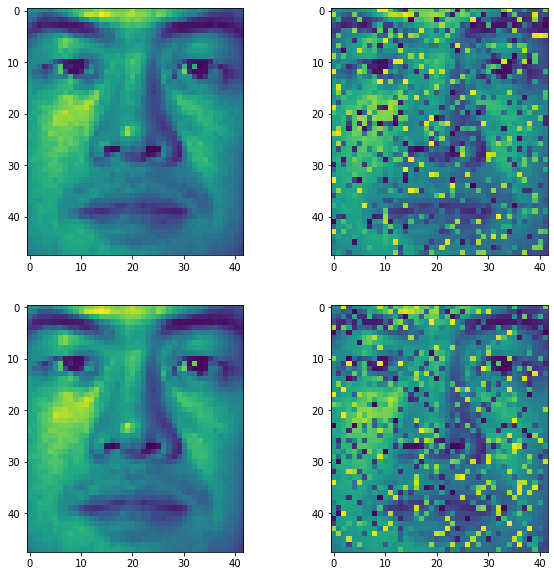

In [92]:
perc = 0.3
k = 1

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(y_ds[:,k].reshape(y_ds_sh))
plt.subplot(222)
plt.imshow(corrupt(y_ds, perc)[:,k].reshape(y_ds_sh))
plt.subplot(223)
plt.imshow(y_wave[:,k].reshape(y_wave_sh))
plt.subplot(224)
plt.imshow(corrupt(y_wave, perc)[:,k].reshape(y_wave_sh))
plt.show()

In [50]:
def evaluate_robust(A, y, train_gt, test_gt, ld_func=down_samp):
    
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    
#     corrupt_percs = np.arange(0,1,0.1)
    corrupt_percs = [0, 0.4, 0.6]
    test_acc = []
    for perc in corrupt_percs:
        corrupt_y = corrupt(y_ld, perc)
        for i in tqdm(range(len(test_pred))):
            test_pred[i] = robust_identity(A_ld, corrupt_y[:,i], train_gt)

    #     print(train_pred)
        test_acc.append(accuracy_score(test_gt, test_pred)*100)
    
    print("Robust Identity Accuracy for {}:\n\tTest Accuracy: {}".format(ld_func.__name__, test_acc))
    return test_acc

In [51]:
#TODO: Change train and test data for robust
#TODO: Change ds factor for robust

test_accs = []
for func in down_samp_funcs:
    test_accs.append(evaluate_robust(A, y, train_gt, test_gt, ld_func=func))

100%|██████████| 1207/1207 [01:18<00:00, 15.47it/s]


Robust Identity Accuracy for down_samp:
	Test Accuracy: [87.90389395194697, 74.97928748964374, 35.87406793703397]


100%|██████████| 1207/1207 [00:52<00:00, 22.87it/s]


Robust Identity Accuracy for down_samp_wave:
	Test Accuracy: [87.07539353769677, 37.86246893123447, 8.20215410107705]


100%|██████████| 1207/1207 [01:08<00:00, 17.58it/s]

Robust Identity Accuracy for down_samp_pca:
	Test Accuracy: [89.6437448218724, 67.35708367854184, 43.66197183098591]
